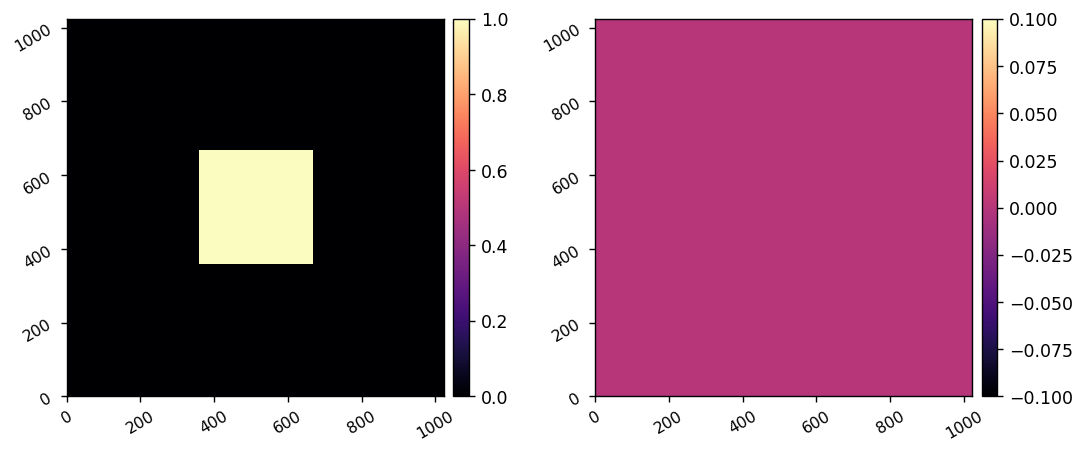

In [62]:
import numpy as np
import cupy as cp
import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output
from importlib import reload

from roman_cgi_iefc_2.poppy_roman_cgi_phasec import cgi
from roman_cgi_iefc_2 import iefc_utils as iefcu
from roman_cgi_iefc_2 import iefc_sim_2dm as iefc2

import misc

data_dir = Path('/groups/douglase/kians-data-files/roman-cgi-iefc-data')
flatmaps_dir = Path.home()/'src/pyfalco/roman/flatmaps'

dm1_flatmap = 2*fits.getdata(flatmaps_dir/'dm1_m_flat_hlc_band1.fits')
dm2_flatmap = 2*fits.getdata(flatmaps_dir/'dm2_m_flat_hlc_band1.fits')
dm1_design = 2*fits.getdata(flatmaps_dir/'dm1_m_design_hlc_band1.fits')
dm2_design = 2*fits.getdata(flatmaps_dir/'dm2_m_design_hlc_band1.fits')

def reset(quiet=False):
    reload(iefcu)
    reload(iefc2)
    reload(cgi)
    hlci = cgi.CGI_POPPY(polaxis=0, use_opds=False, use_fieldstop=False, quiet=quiet, ngpus=1/4)
#     hlci.set_dm1(dm1_flatmap)
#     hlci.set_dm2(dm2_flatmap)
#     hlci.set_dm1(dm1_design)
#     hlci.set_dm2(dm2_design)
    return hlci

hlci = reset()
misc.myimshow2(hlci.inwave.intensity.get(), hlci.inwave.phase.get())

npsf = hlci.npsf
Nact = hlci.Nact

(calc_psf pid=54060) Propagating wavelength 575.000 nm.
All PSFs calculated in 0.450s
(calc_psf pid=54060) PSF calculated in 0.41s


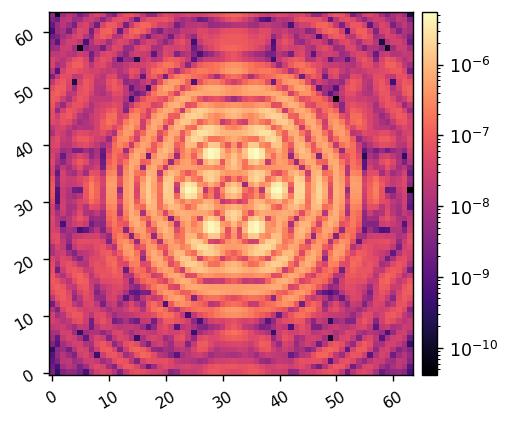

In [63]:
hlci = reset()
ref_psf = hlci.calc_psfs()[0][-1]
misc.myimshow(ref_psf.intensity.get(), lognorm=True)

# Create dark hole ROI to calibrate and control

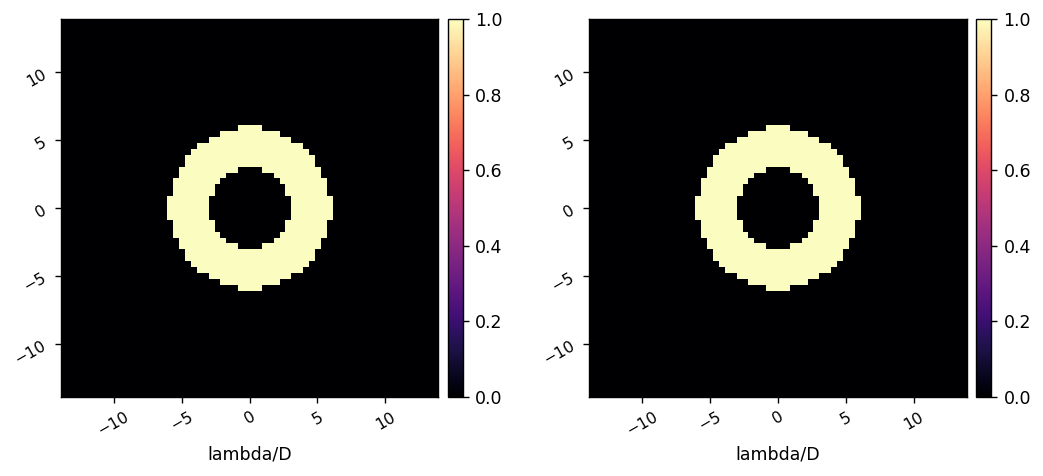

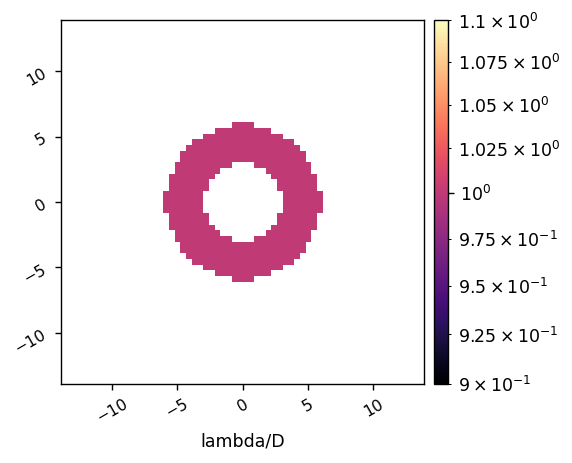

In [65]:
hlci = reset()
xfp = np.linspace(-0.5, 0.5, npsf) * npsf * hlci.psf_pixelscale_lamD
xf,yf = np.meshgrid(xfp,xfp)

edge = 2
iwa = 3
owa = 6
direction = None
# Create the mask that is used to select which region to make dark.
dh_params = {
    'inner_radius' : iwa,
    'outer_radius' : owa,
    'edge_position' : edge,
    'direction' : direction
}
dh_mask = iefcu.create_annular_focal_plane_mask(xf, yf, dh_params).ravel()

#Create the mask that is used to select which region to make dark.
control_params = {
    'inner_radius' : iwa,
    'outer_radius' : owa,
    'edge_position' : edge,
    'direction' : direction
}
control_mask = iefcu.create_annular_focal_plane_mask(xf, yf, control_params).ravel()

relative_weight = 0.99
weights = dh_mask * relative_weight + (1 - relative_weight) * control_mask

misc.myimshow2(dh_mask.reshape(npsf,npsf), control_mask.reshape(npsf,npsf), 
               pxscl1=hlci.psf_pixelscale_lamD, pxscl2=hlci.psf_pixelscale_lamD)
misc.myimshow(weights.reshape(npsf,npsf), lognorm=True, pxscl=hlci.psf_pixelscale_lamD)

# Create probe and fourier modes

Creating Fourier modes:  (64, 64)
Calibration modes required: 224


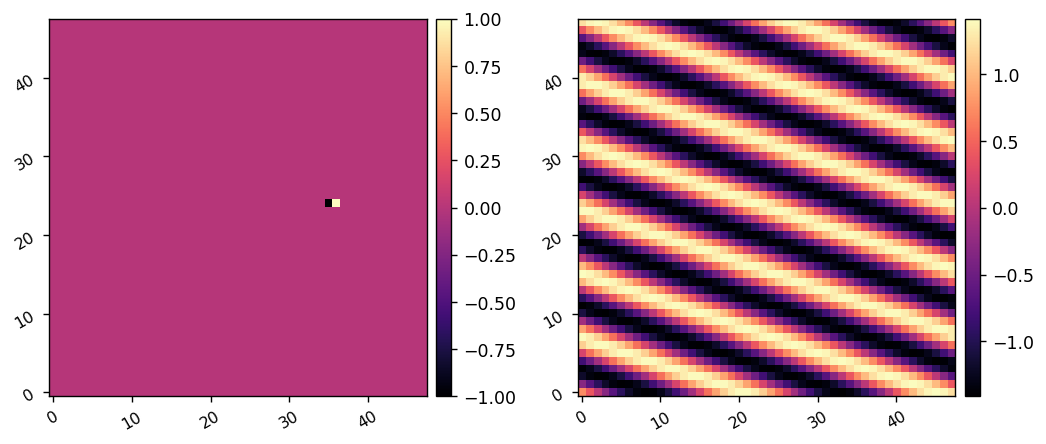

(True, True)

In [66]:
hlci = reset()

probe_modes = iefcu.create_probe_poke_modes(Nact, 3*Nact//4, Nact//2, 3*Nact//4-1, Nact//2)
calibration_modes, fx, fy = iefcu.create_fourier_modes(xfp, control_mask.reshape((npsf,npsf)), Nact, circular_mask=False)

calibration_amplitude = 0.006 * hlci.wavelength_c.to(u.m).value
probe_amplitude = 0.05 * hlci.wavelength_c.to(u.m).value
nmodes = calibration_modes.shape[0]

print('Calibration modes required: {:d}'.format(nmodes))
misc.myimshow2((probe_modes[0] - probe_modes[1]).reshape((Nact,Nact)), calibration_modes[0].reshape(Nact,Nact))

isinstance(probe_modes, np.ndarray), isinstance(calibration_modes, np.ndarray)

# Calibrate IEFC (or load in previous calibration data)

In [67]:
fname = 'annular_Nopds_polaxis{:d}_iwa{:.1f}_owa{:.1f}'.format(hlci.polaxis, 
                                                               dh_params['inner_radius'], 
                                                               dh_params['outer_radius'])
print(fname)

annular_Nopds_polaxis0_iwa3.0_owa6.0


In [68]:
hlci = reset(quiet=True)

response_cube, calibration_cube = iefc2.calibrate(hlci, probe_amplitude, probe_modes, 
                                                  calibration_amplitude, calibration_modes, start_mode=0)

Calibrating I-EFC...
	Calibrated mode 1 / 224 in 3.752s
	Calibrated mode 2 / 224 in 7.461s
	Calibrated mode 3 / 224 in 11.121s
	Calibrated mode 4 / 224 in 14.786s
	Calibrated mode 5 / 224 in 18.485s
	Calibrated mode 6 / 224 in 22.192s
	Calibrated mode 7 / 224 in 25.958s
	Calibrated mode 8 / 224 in 29.674s
	Calibrated mode 9 / 224 in 33.381s
	Calibrated mode 10 / 224 in 37.072s
	Calibrated mode 11 / 224 in 40.748s
	Calibrated mode 12 / 224 in 44.445s
	Calibrated mode 13 / 224 in 48.135s
	Calibrated mode 14 / 224 in 51.808s
	Calibrated mode 15 / 224 in 55.477s
	Calibrated mode 16 / 224 in 59.275s
	Calibrated mode 17 / 224 in 62.958s
	Calibrated mode 18 / 224 in 66.723s
	Calibrated mode 19 / 224 in 70.447s
	Calibrated mode 20 / 224 in 74.141s
	Calibrated mode 21 / 224 in 77.823s
	Calibrated mode 22 / 224 in 81.501s
	Calibrated mode 23 / 224 in 85.245s
	Calibrated mode 24 / 224 in 89.024s
	Calibrated mode 25 / 224 in 92.739s
	Calibrated mode 26 / 224 in 96.429s
	Calibrated mode 27 / 224 in

	Calibrated mode 215 / 224 in 797.193s
	Calibrated mode 216 / 224 in 800.831s
	Calibrated mode 217 / 224 in 804.512s
	Calibrated mode 218 / 224 in 808.199s
	Calibrated mode 219 / 224 in 811.876s
	Calibrated mode 220 / 224 in 815.554s
	Calibrated mode 221 / 224 in 819.228s
	Calibrated mode 222 / 224 in 822.953s
	Calibrated mode 223 / 224 in 826.757s
	Calibrated mode 224 / 224 in 830.416s
Calibration complete.


In [69]:
iefcu.save_pickle(data_dir/'response-data'/fname, response_cube)
iefcu.save_pickle(data_dir/'calibration-data'/fname, calibration_cube)

Saved wavefronts to:  /groups/douglase/kians-data-files/roman-cgi-iefc-data/response-data/annular_Nopds_polaxis0_iwa3.0_owa6.0
Saved wavefronts to:  /groups/douglase/kians-data-files/roman-cgi-iefc-data/calibration-data/annular_Nopds_polaxis0_iwa3.0_owa6.0


In [70]:
response_cube = iefcu.load_pickle(data_dir/'response-data'/fname)
calibration_cube = iefcu.load_pickle(data_dir/'calibration-data'/fname)

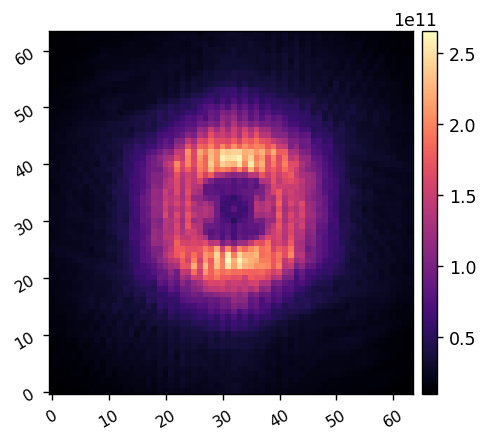

In [71]:
response_sum = np.sum(abs(response_cube), axis=(0,1))
misc.myimshow(response_sum.reshape(64,64))

# Create control matrix

In [73]:
hlci = reset()

# OPTIONAL: Filter the calibration files by subtracting PCA modes
# npca = 3
# filtered_response_cube, pca_modes = iefc.remove_k_pca_modes(response_cube, k=npca)

rcond1 = 0.01
rcond2 = 0.01
control_matrix_1 = iefc2.construct_control_matrix(response_cube, cp.array(weights), 
                                                  rcond1=rcond1, rcond2=rcond2, WLS=True,) 
control_matrix_2 = iefc2.construct_control_matrix(response_cube, cp.array(weights), 
                                                  rcond1=rcond1, rcond2=rcond2, WLS=False,) 

Using Weighted Least Squares 
Using Tikhonov Inverse


In [74]:
isinstance(probe_modes, np.ndarray), isinstance(calibration_modes, np.ndarray)

(True, True)

# Run IEFC

Running I-EFC...
	Closed-loop iteration 1 / 10


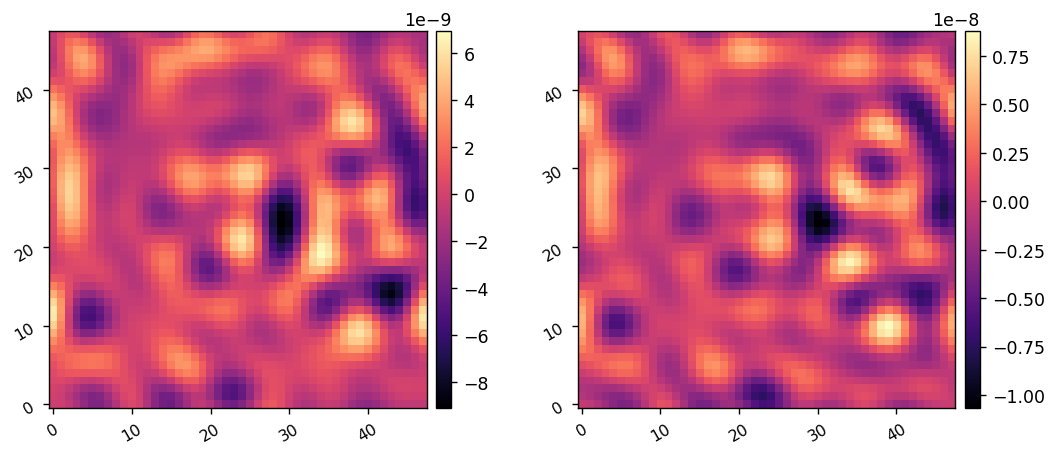

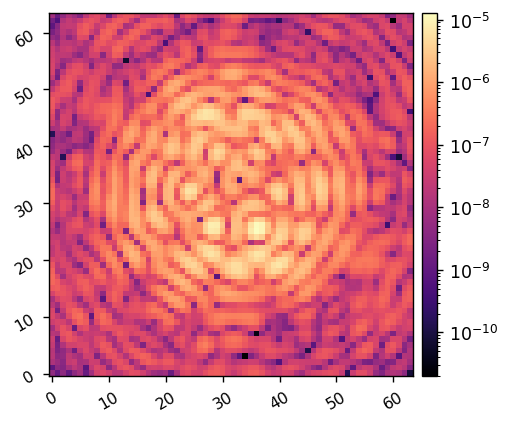

	Closed-loop iteration 2 / 10


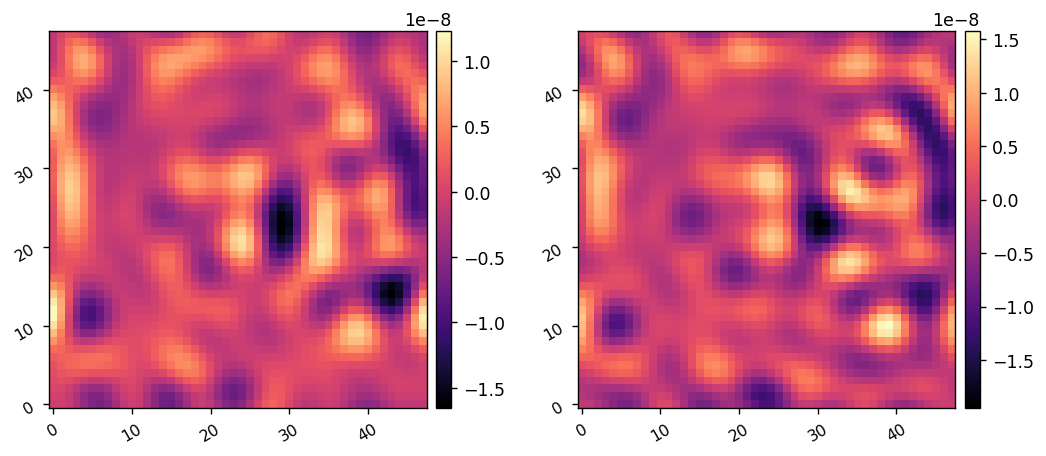

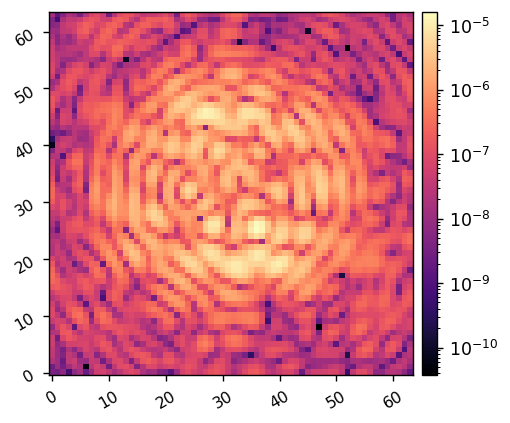

	Closed-loop iteration 3 / 10


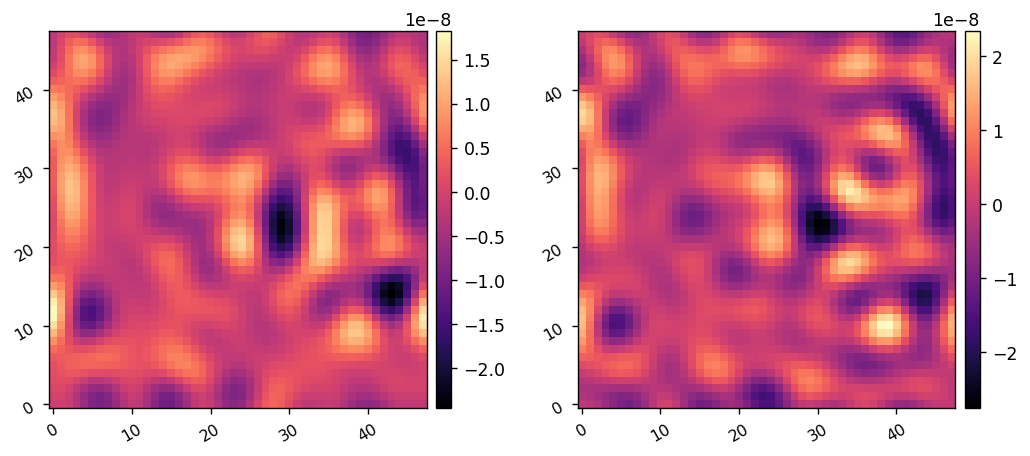

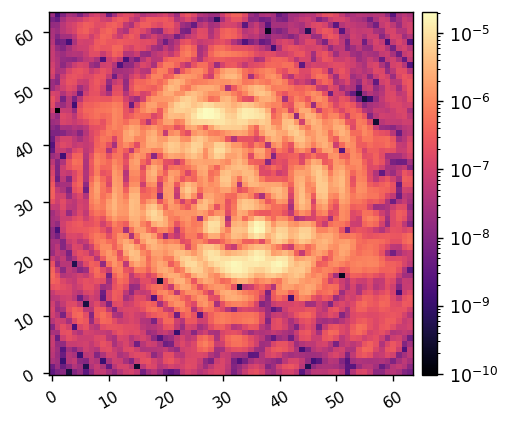

	Closed-loop iteration 4 / 10


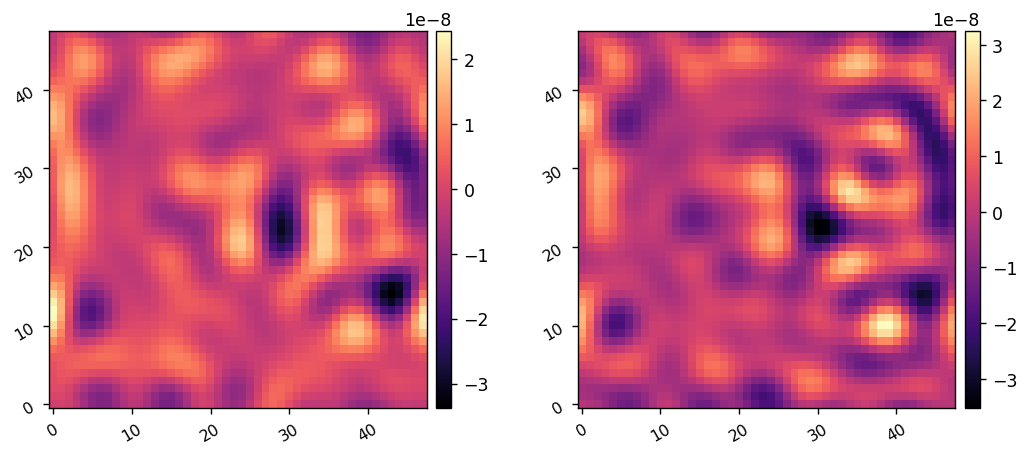

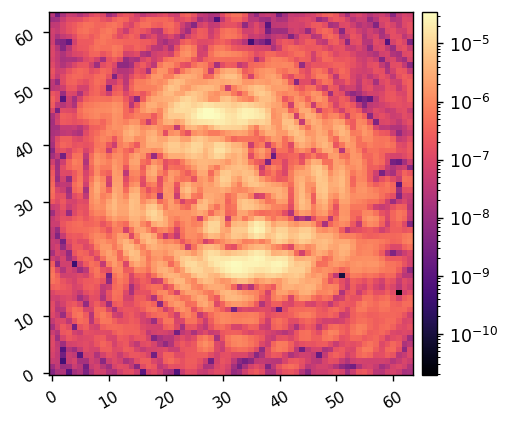

	Closed-loop iteration 5 / 10


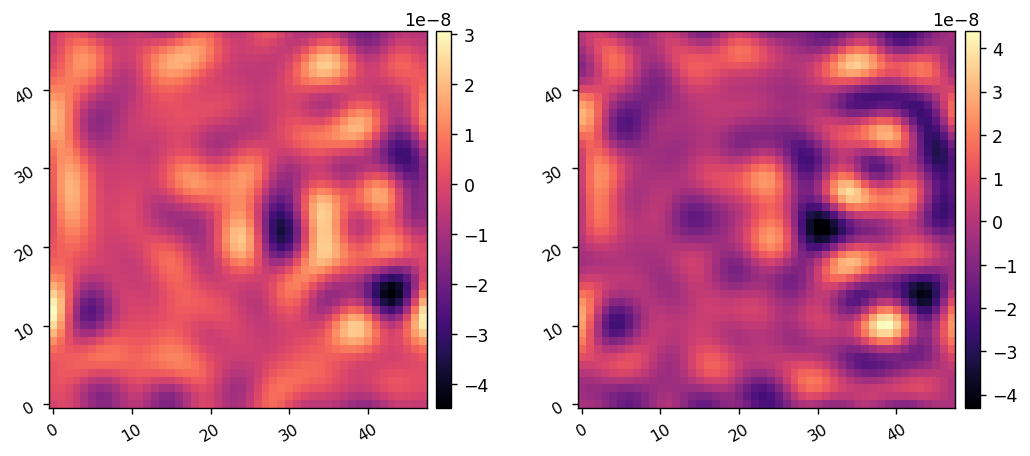

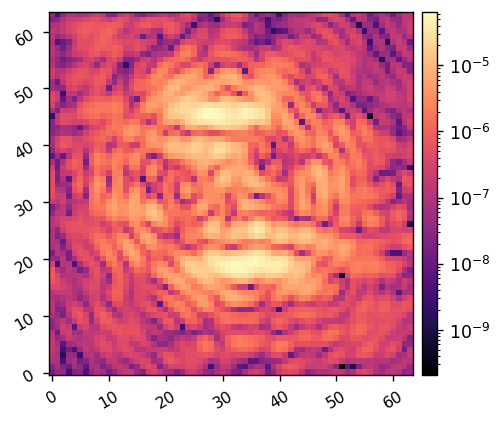

	Closed-loop iteration 6 / 10


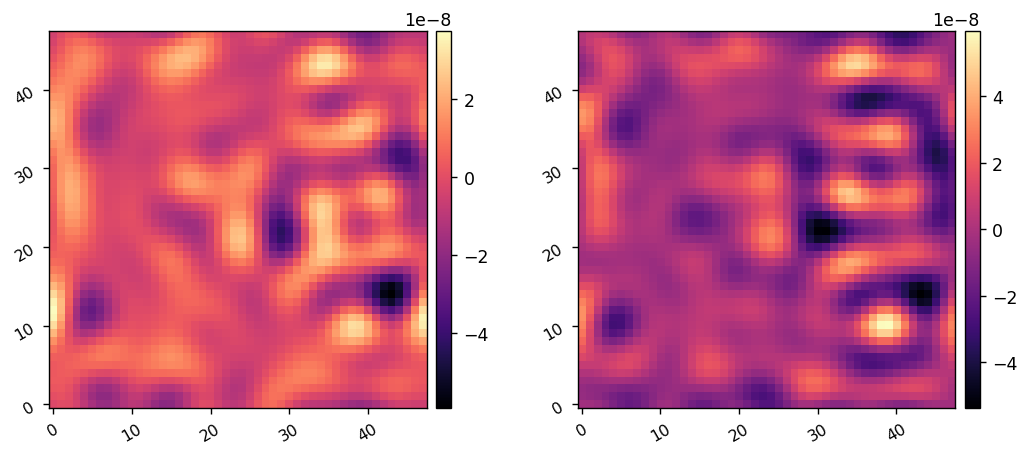

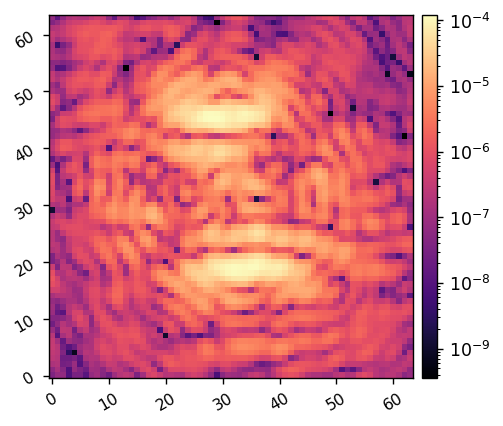

	Closed-loop iteration 7 / 10


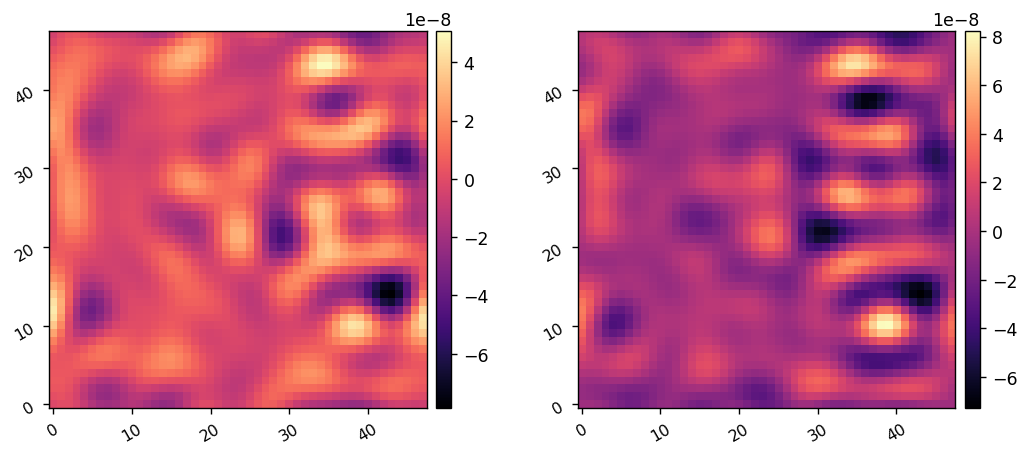

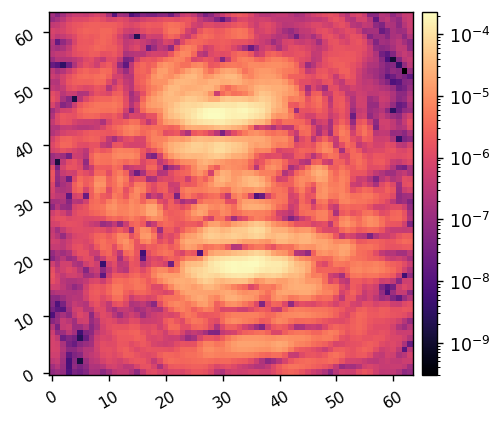

	Closed-loop iteration 8 / 10


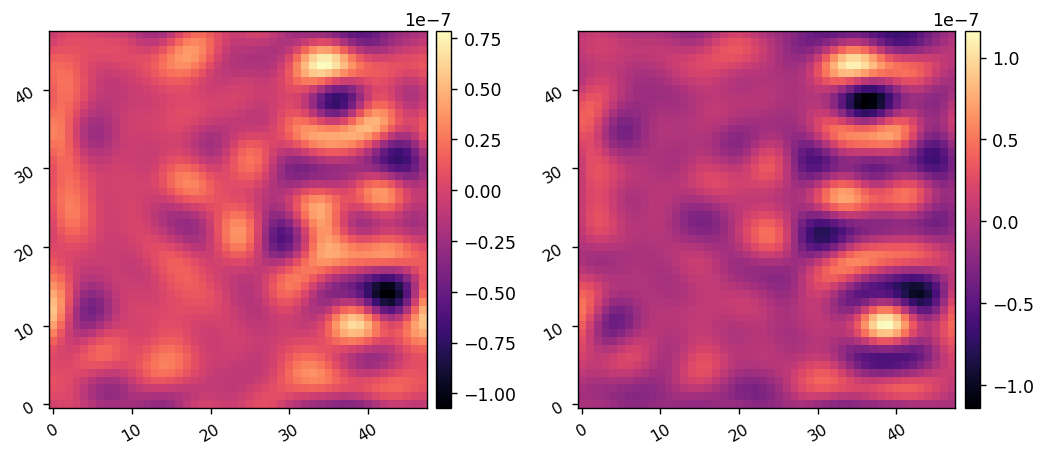

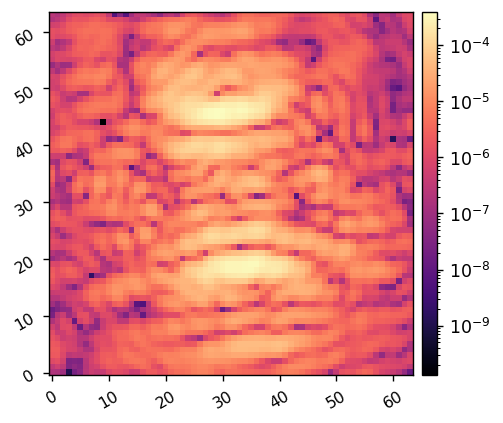

	Closed-loop iteration 9 / 10


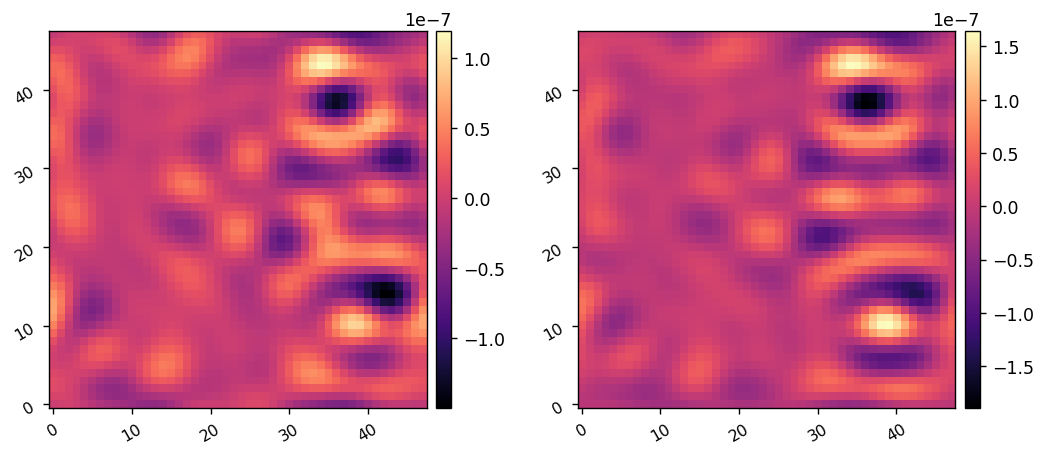

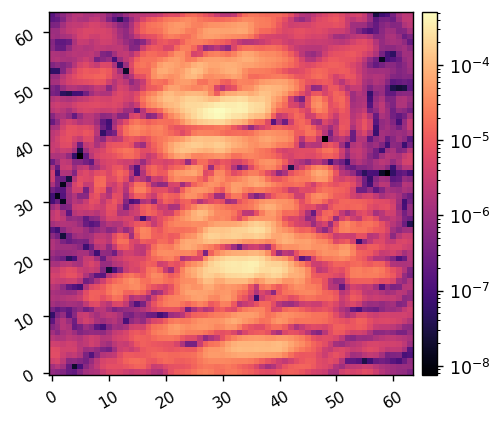

	Closed-loop iteration 10 / 10


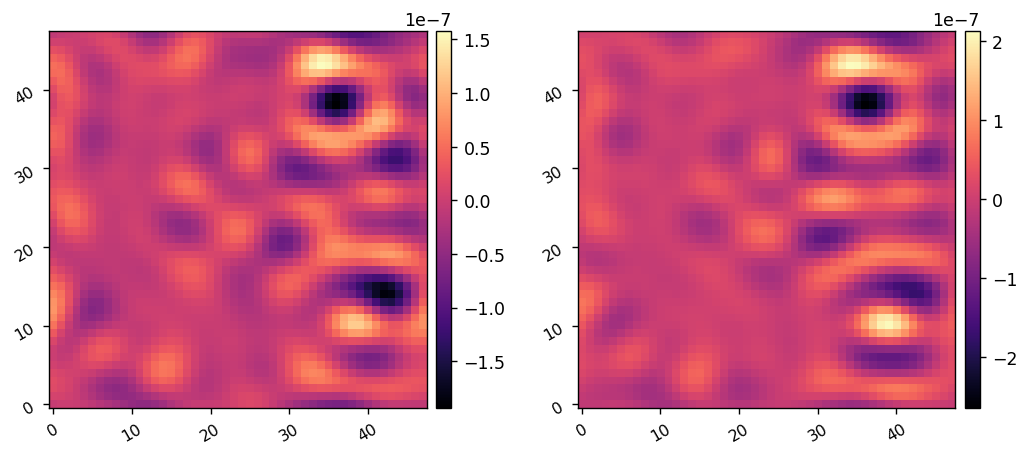

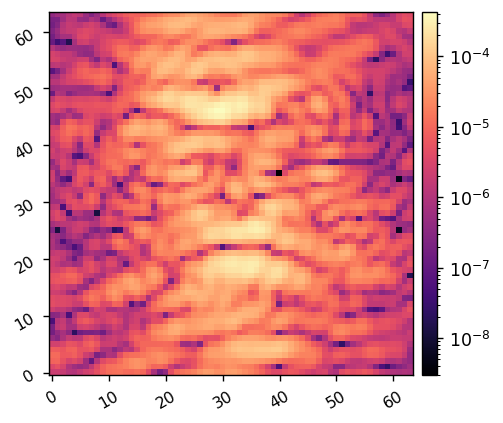

I-EFC loop completed in 22.672s.


In [78]:
hlci = reset(quiet=True)

images, dm1_commands, dm2_commands = iefc2.run(hlci, control_matrix_1, probe_modes, probe_amplitude, 
                                               calibration_modes, cp.array(weights), 
                                               num_iterations=10, gain=-0.5, leakage=0.0,
                                               display=True)

In [58]:
iefcu.save_pickle(data_dir/'image-results'/fname, images)
iefcu.save_pickle(data_dir/'dm-results'/(fname+'_dm1'), dm1_commands)
iefcu.save_pickle(data_dir/'dm-results'/(fname+'_dm2'), dm2_commands)


Saved wavefronts to:  /groups/douglase/kians-data-files/roman-cgi-iefc-data/image-results/annular_Nopds_polaxis0_iwa3.0_owa6.0
Saved wavefronts to:  /groups/douglase/kians-data-files/roman-cgi-iefc-data/dm-results/annular_Nopds_polaxis0_iwa3.0_owa6.0_dm1
Saved wavefronts to:  /groups/douglase/kians-data-files/roman-cgi-iefc-data/dm-results/annular_Nopds_polaxis0_iwa3.0_owa6.0_dm2


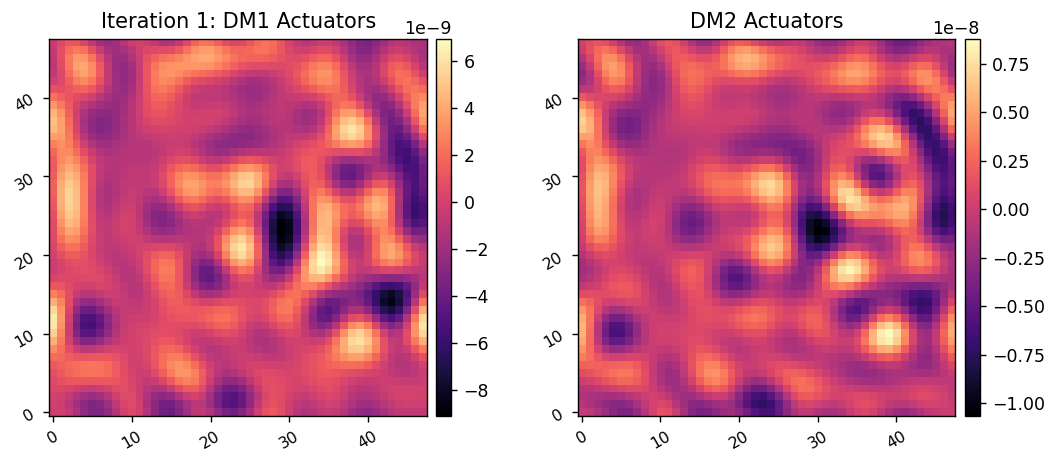

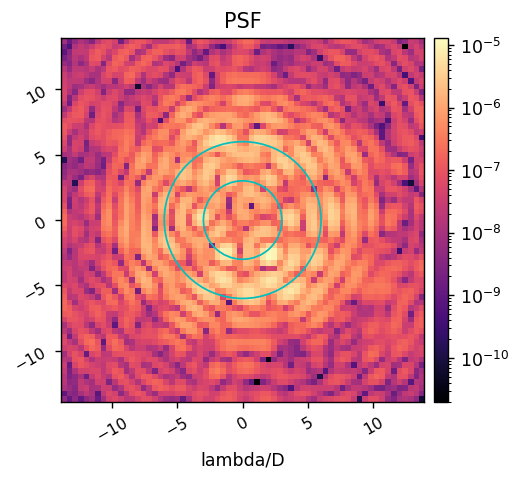

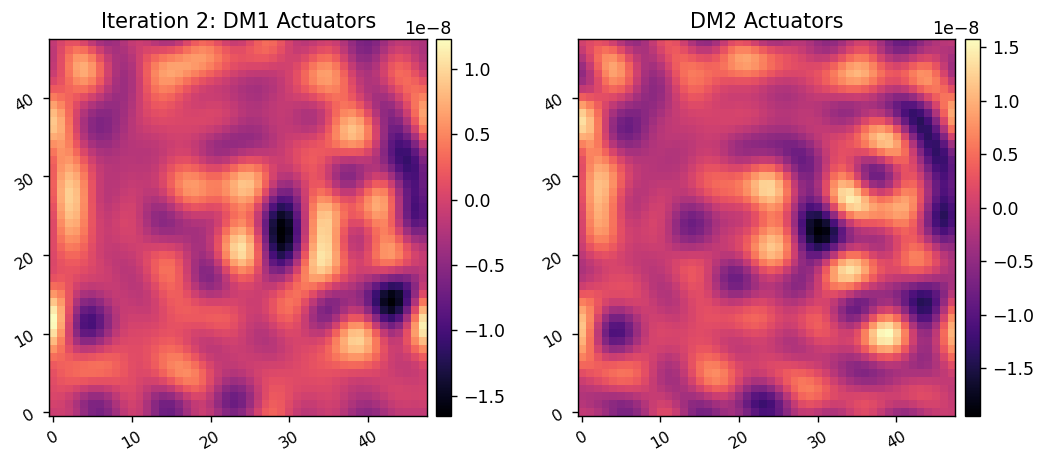

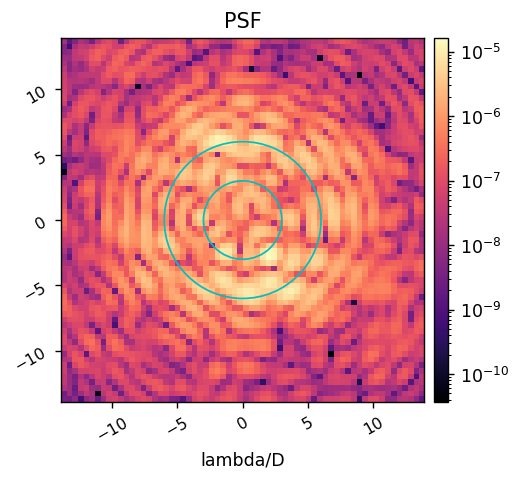

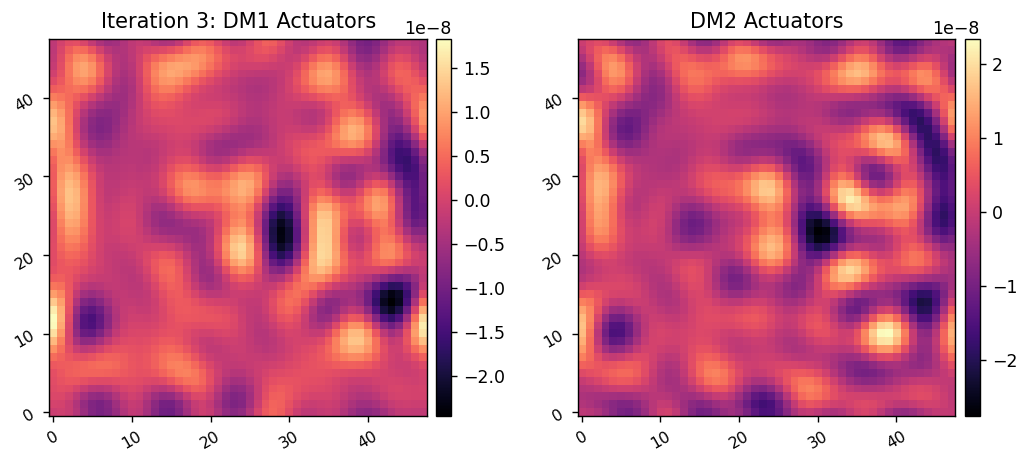

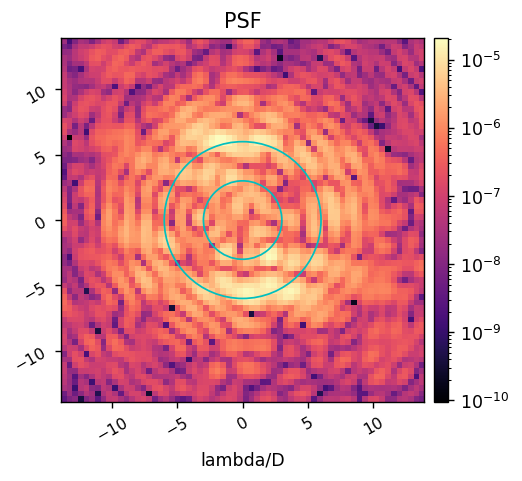

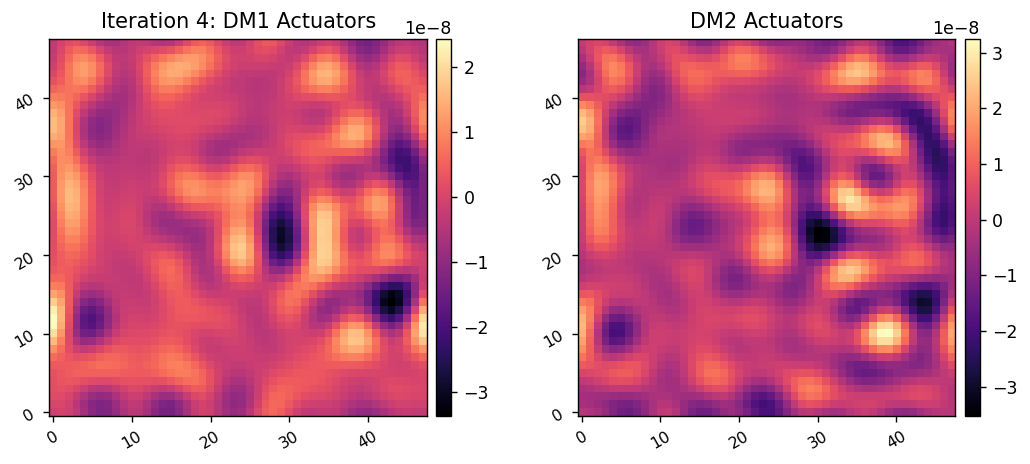

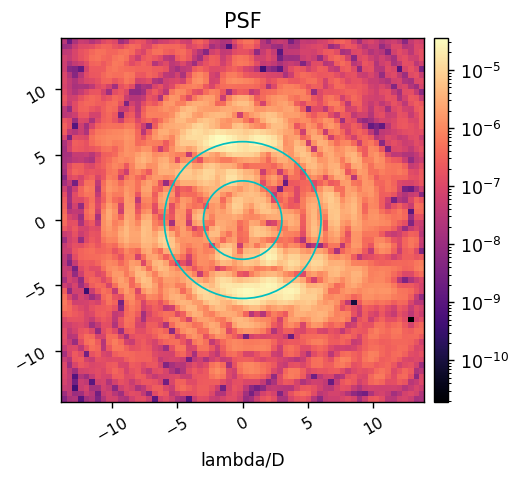

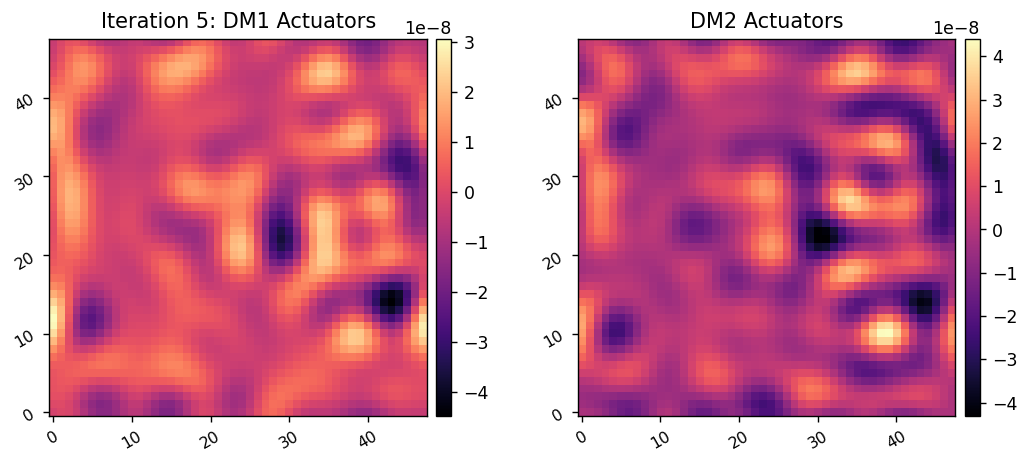

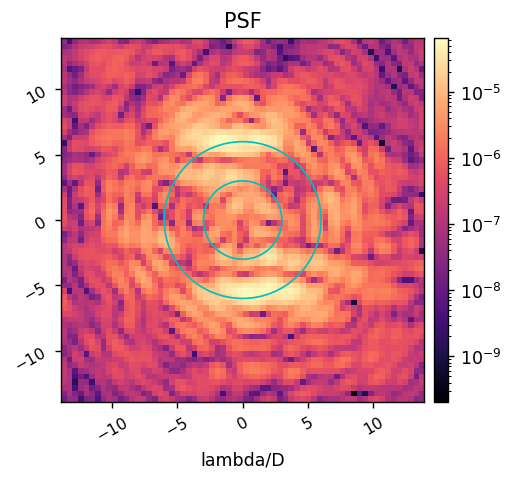

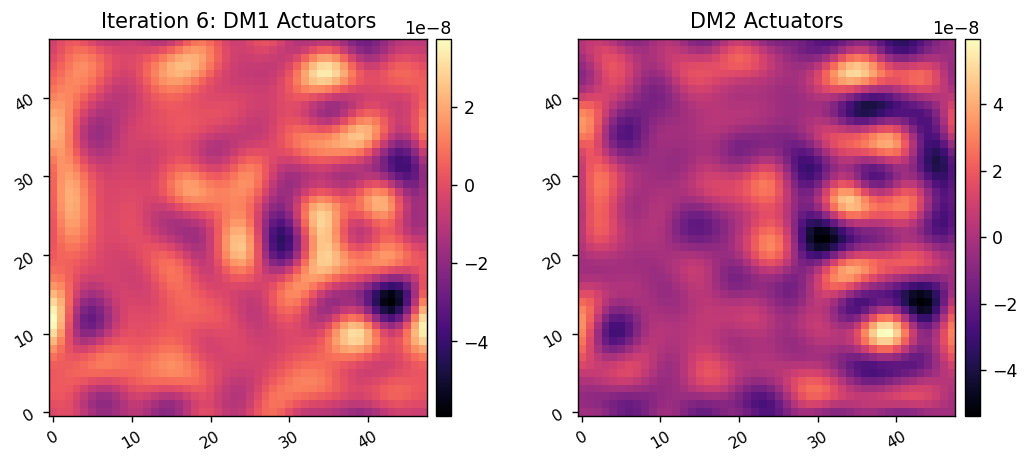

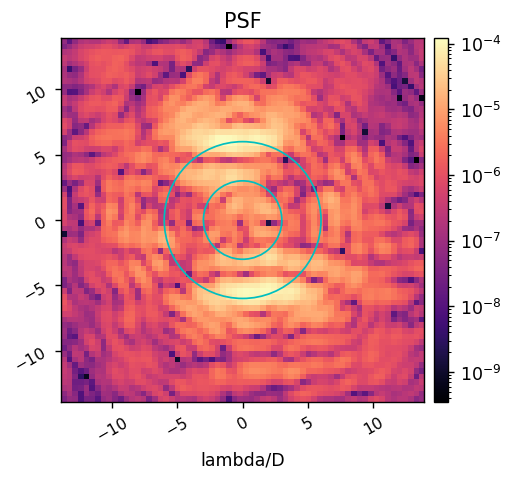

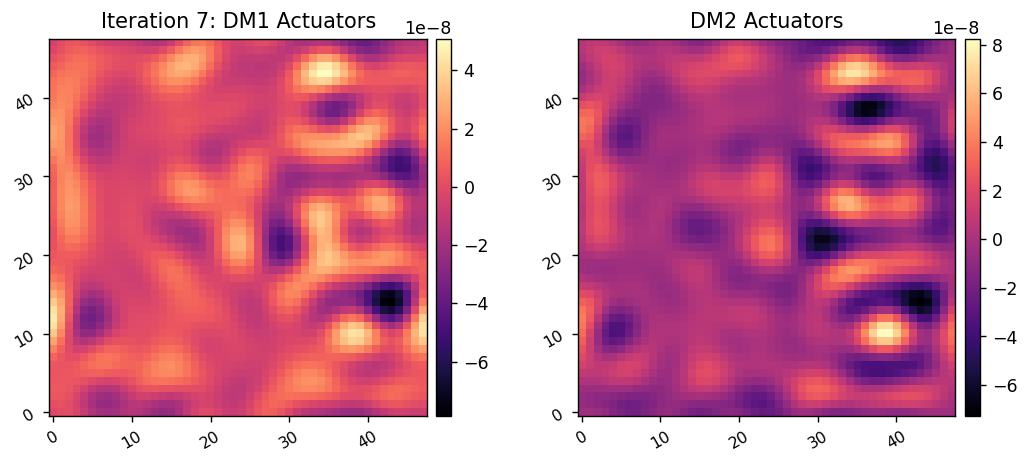

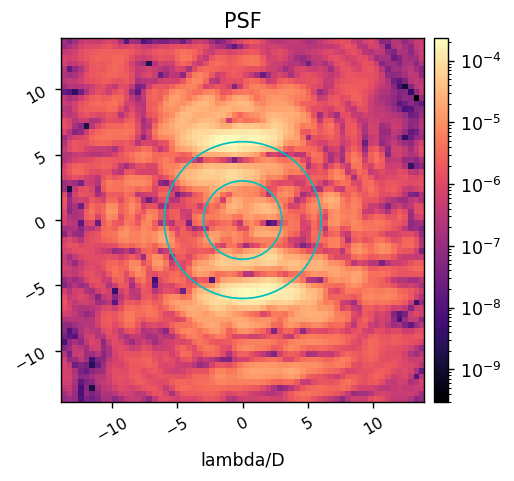

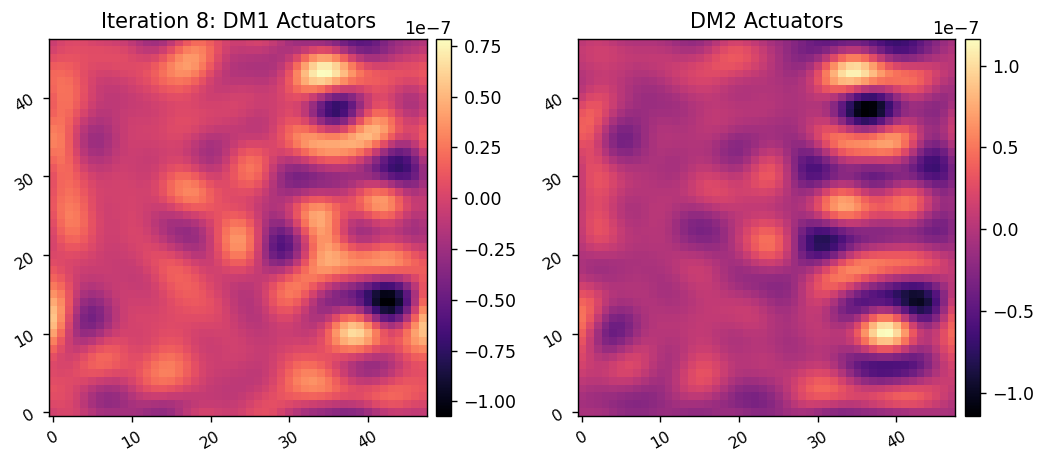

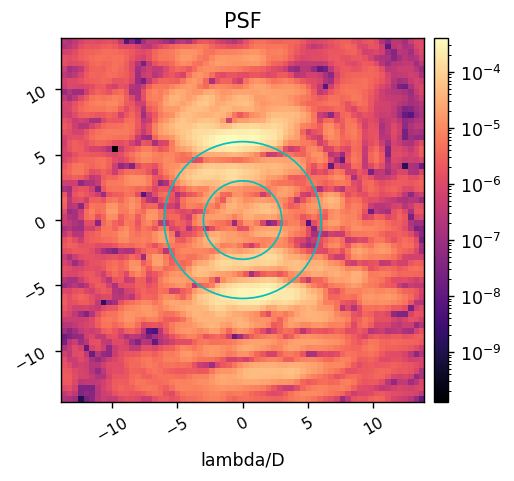

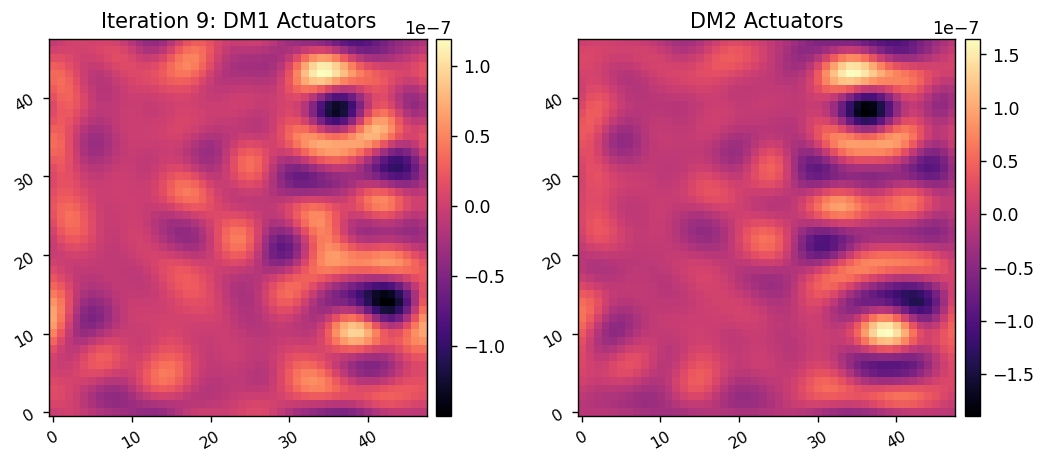

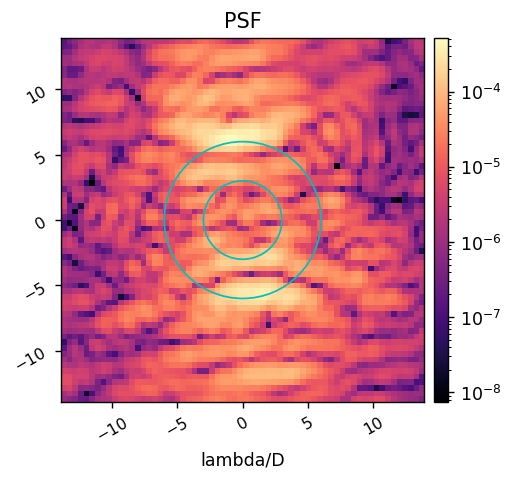

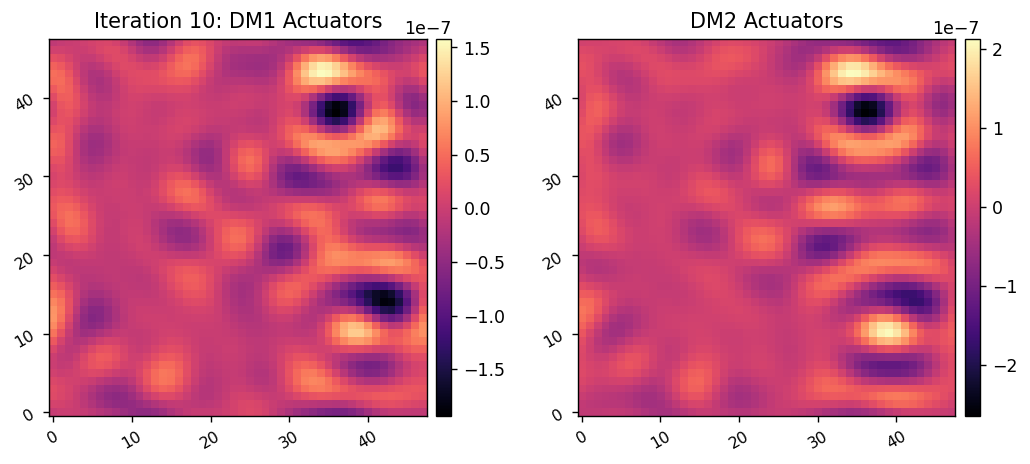

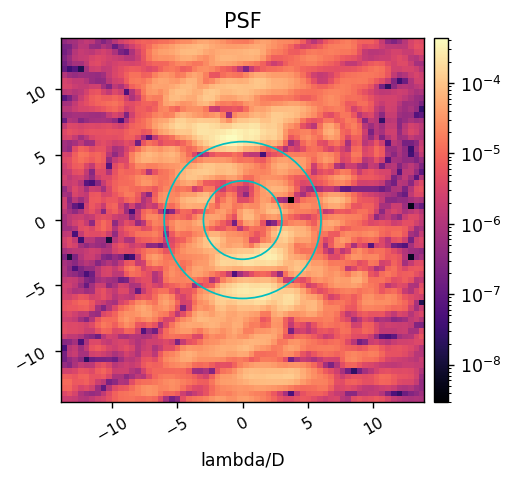

In [79]:
for i in range(len(images)):
    patches = iefcu.create_circ_patches(dh_params)
    misc.myimshow2(dm1_commands[i], dm2_commands[i], 
                   'Iteration {:d}: DM1 Actuators'.format(i+1), 'DM2 Actuators',)
    misc.myimshow(images[i].intensity, 'PSF', lognorm=True, pxscl=hlci.psf_pixelscale_lamD, patches=patches)